# ML Models for Detecting Onset Diabetes

In [131]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tabulate import tabulate
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split, ParameterGrid, cross_val_score, RepeatedKFold, RepeatedStratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
import warnings  as ws
ws.filterwarnings("ignore")

In [132]:
# load the dataframe
df=pd.read_csv("C:\\Users\\hp\\Documents\\data related articles\\diabetes\\Dataset & Notebook\\diabetes dataset 2.csv")

### Surface-level information and Shape

In [133]:
# print out the head of the dataframe and the shape
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,2,138,62,35,0,33.6,0.127,47,1
1,0,84,82,31,125,38.2,0.233,23,0
2,0,145,0,0,0,44.2,0.630,31,1
3,0,135,68,42,250,42.3,0.365,24,1
4,1,139,62,41,480,40.7,0.536,21,0


## Exploratory Data Analysis

In [134]:
# get the shape
df.shape

(2000, 9)

**Insight**: We have 2000 rows/samples and 9 columns. 8 of the 9 columns are our *feature* columns, while the last column (Outcome) represents our *target* column. Moreover, all of our columns appear to consist of numeric data. Let's look at how much of each class we have:

In [135]:
df["Outcome"].value_counts()

0    1316
1     684
Name: Outcome, dtype: int64

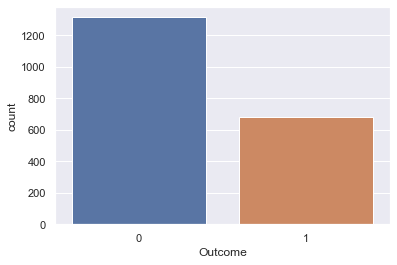

In [136]:
sns.set()
sns.countplot(df["Outcome"])
plt.show()

**Insight**: Our data set consists of 1316 healthy individuals and only 684 diabetic individuals; evidently, our data set is imbalanced. We will need to deal with this later.

### Checking for Null and Duplicate Entries

In [137]:
# check for null entries
df.isna().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [138]:
# check for duplicate entries
num_duplicate_entries = df.duplicated(subset=None, keep='first').sum()
num_duplicate_entries

1256

In [139]:
# to which class do the duplicates belong to
duplicate_data = df[df.duplicated(subset=None, keep='first')]
duplicate_data.Outcome.value_counts()

0    825
1    431
Name: Outcome, dtype: int64

**Insight**: We don't have any null/missing values, however, we do have 1256 duplicate values--825 of which belong to the healthy class, and 431 of which belong to the diabetic class.

### Feature Analysis
Now that we have a decent understanding of the structure of our data, let's dive deeper by exploring the features themselves and how they might impact our target variable. To start, we can take a look at the correlation of the features:

<AxesSubplot:>

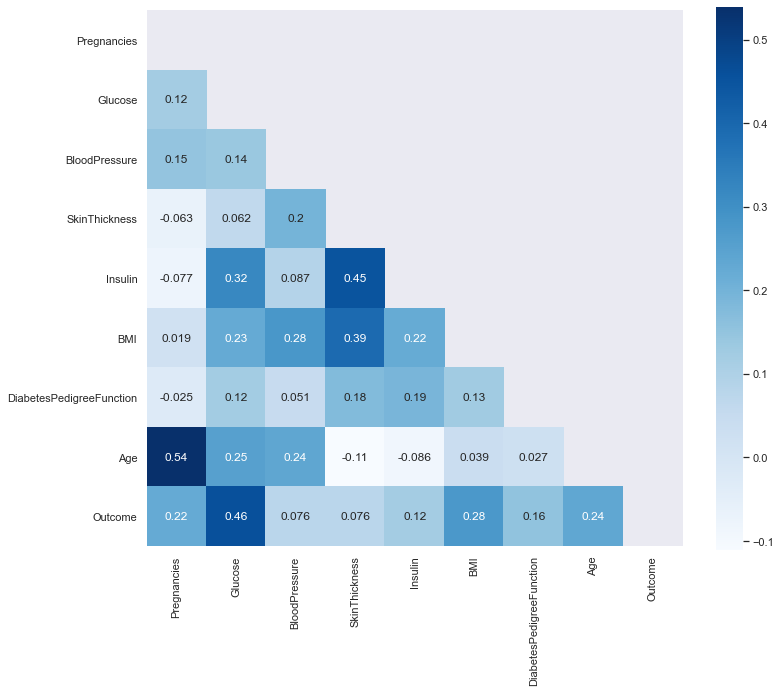

In [140]:
corr = df.corr() # compute the correlation matrix
mask = np.triu(np.ones_like(corr, dtype=bool)) # define the upper-triangular mask for the heatmap
cmap = sns.color_palette("Blues", as_cmap=True) # define the color palette to use
plt.figure(figsize=(12, 10)) # update the figure size to dispaly nicely
sns.heatmap(corr, mask=mask, cmap=cmap, square=True, annot=True)

**Insight**: The features neither have a strong correlation with one another nor the target variable. Thus, we should be able to incorporate all of them when building our final model. Let's take a closer look at their correlations and distributions.

<Figure size 864x720 with 0 Axes>

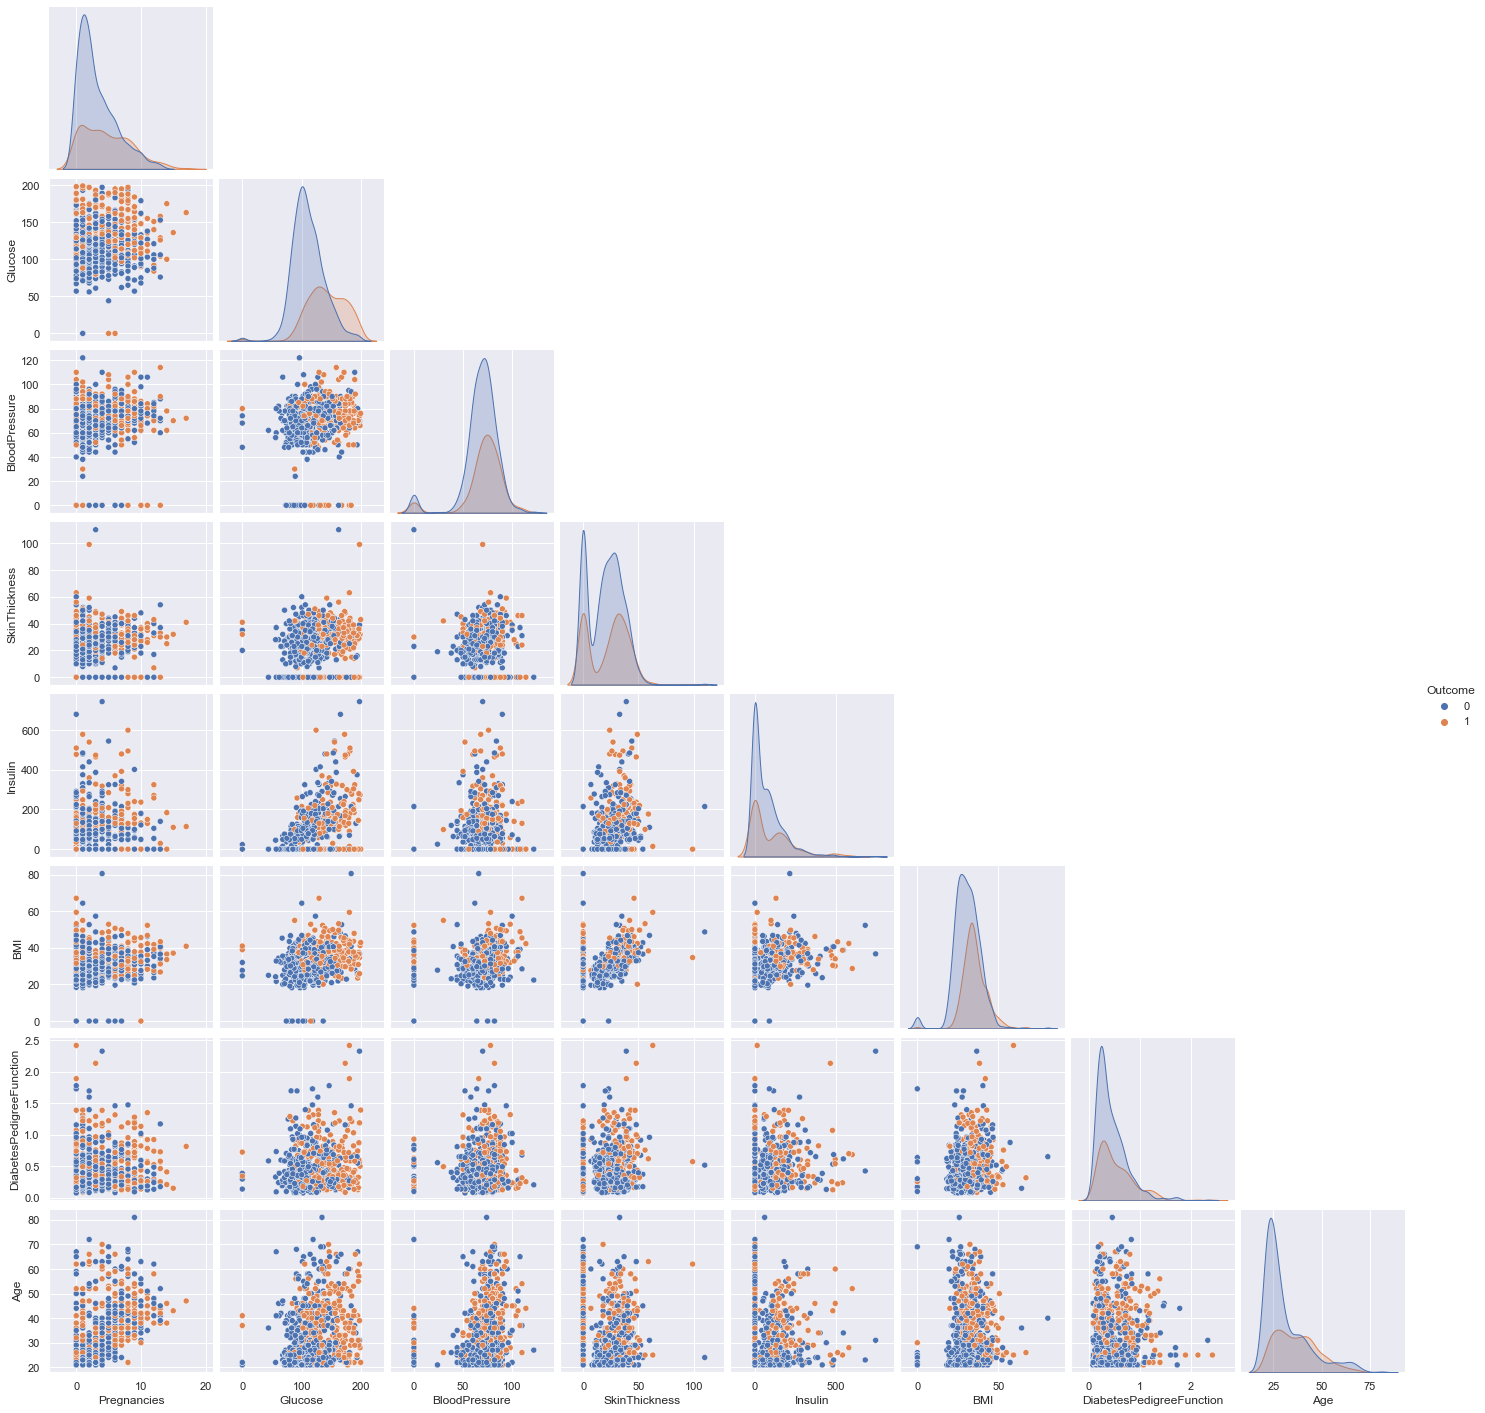

In [141]:
# use pairplot to show relationships between features and individual distributions
plt.figure(figsize=(12, 10))
sns.pairplot(data=df, hue="Outcome", corner=True, diag_kind="kde")

**Insight**: From the scatter plots, we can see that outliers are prevalent within the data set. Moreover, from the KDE distributions on the diagonal, there is a great deal of overlap between healthy and diabetic patients. In other words, there is no subset of features that easily discern healthy individuals from diabetic individuals.

### Outlier Detection
Let's confirm our assumption that outliers exist in the data set by taking a quick glance at the distribution of the data using panda's `describe` method:

In [142]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Pregnancies,2000.0,3.70350,3.306063,0.000,1.000,3.000,6.000,17.00
Glucose,2000.0,121.18250,32.068636,0.000,99.000,117.000,141.000,199.00
BloodPressure,2000.0,69.14550,19.188315,0.000,63.500,72.000,80.000,122.00
SkinThickness,2000.0,20.93500,16.103243,0.000,0.000,23.000,32.000,110.00
Insulin,2000.0,80.25400,111.180534,0.000,0.000,40.000,130.000,744.00
BMI,2000.0,32.19300,8.149901,0.000,27.375,32.300,36.800,80.60
DiabetesPedigreeFunction,2000.0,0.47093,0.323553,0.078,0.244,0.376,0.624,2.42
Age,2000.0,33.09050,11.786423,21.000,24.000,29.000,40.000,81.00
Outcome,2000.0,0.34200,0.474498,0.000,0.000,0.000,1.000,1.00


**Insight**: In the Glucose, BloodPressure, and BMI columns, there is a large gap from the minimum value to the 25th percentile. Moreover, in many of these columns, the minimum value is zero, which makes little sense in the context of the task (for example, a BloodPressure value of zero indicates that the patient's heart is no longer beating!). In a similar matter, In the Pregnancies, BloodPressure, SkinThickness, Insulin, BMI, and Age columns, there is a large gap from between the 75th percentile to the maximum value, indicating the presence of outliers.

To get a sense for just how many outliers we are dealing with, we can use a box and whisker plot over each of the features:

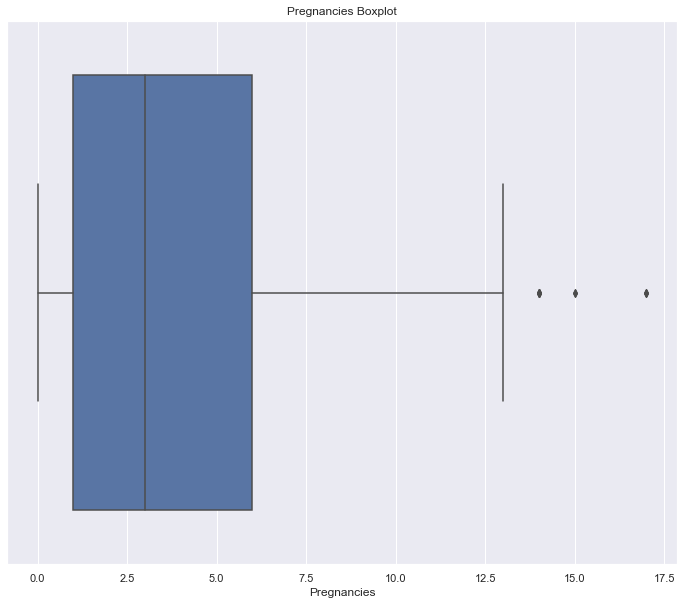

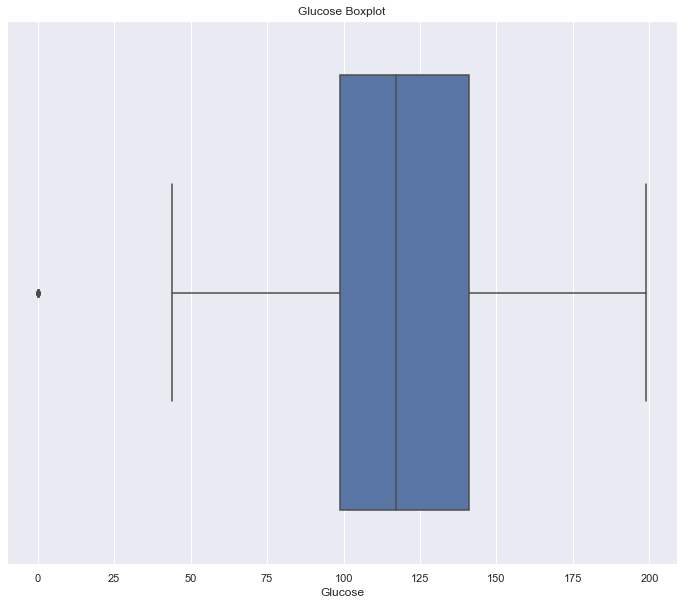

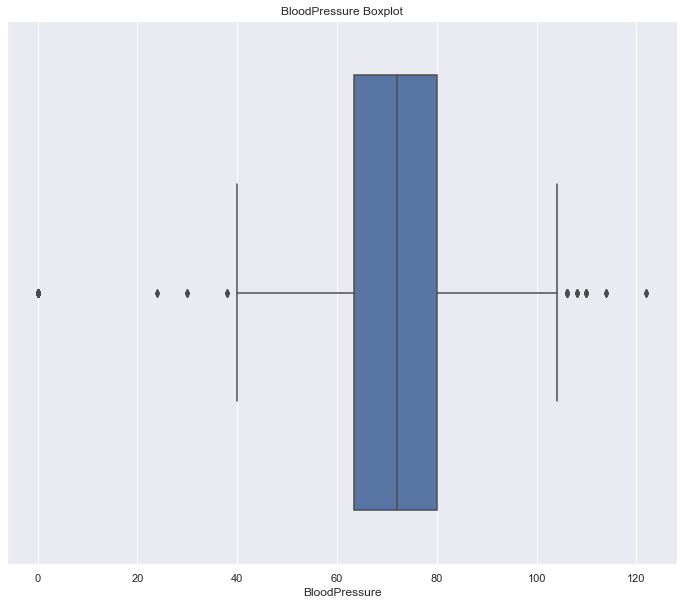

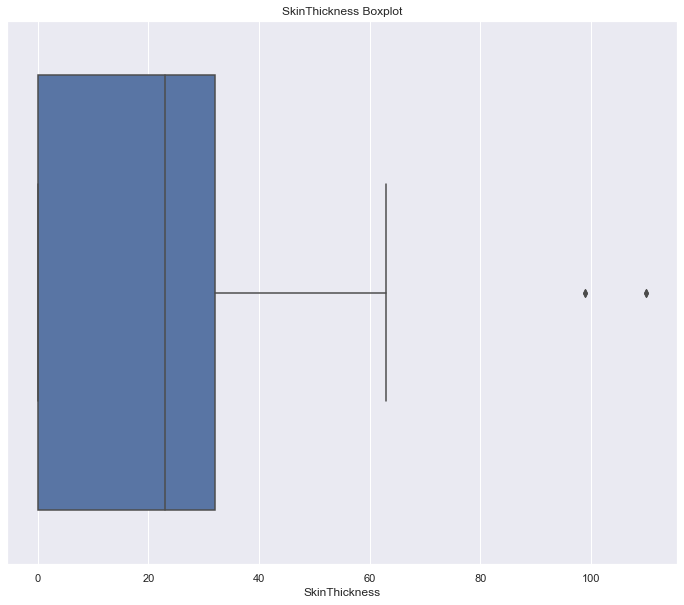

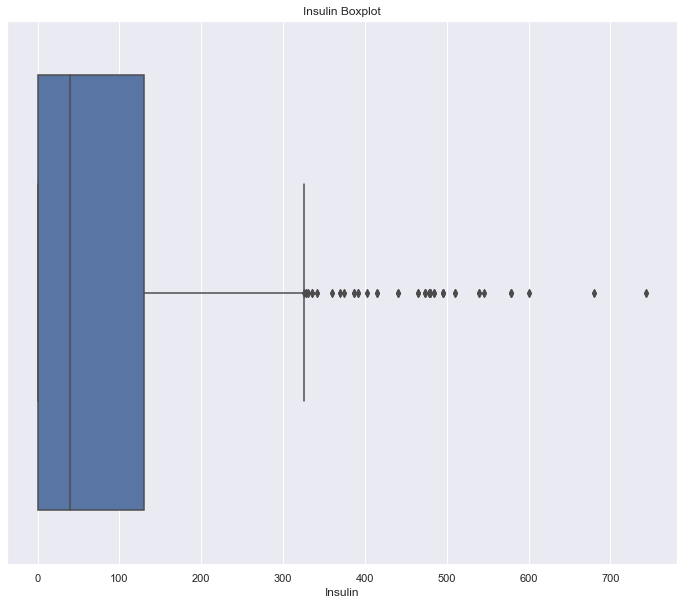

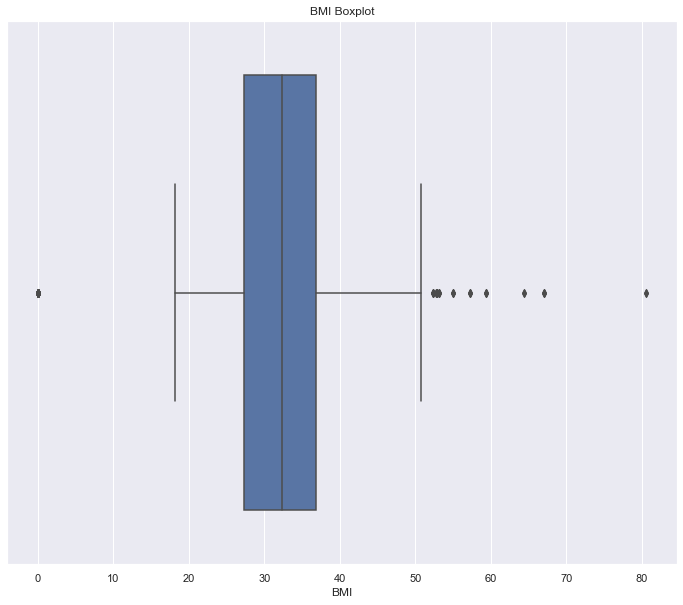

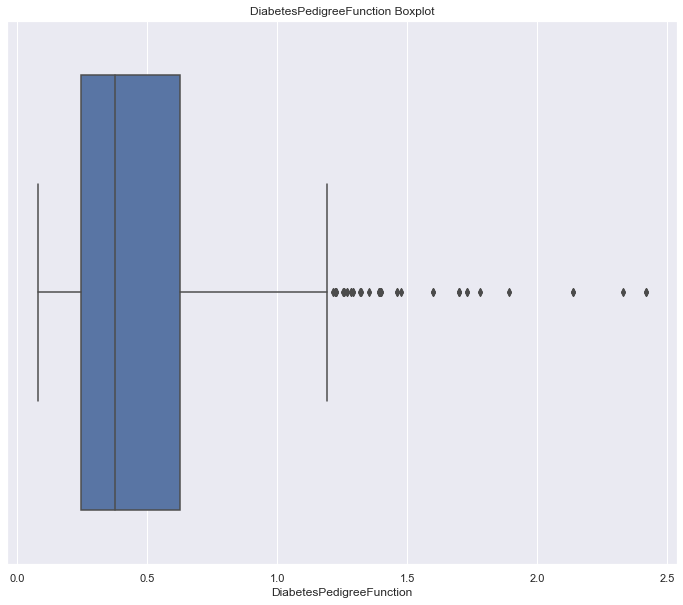

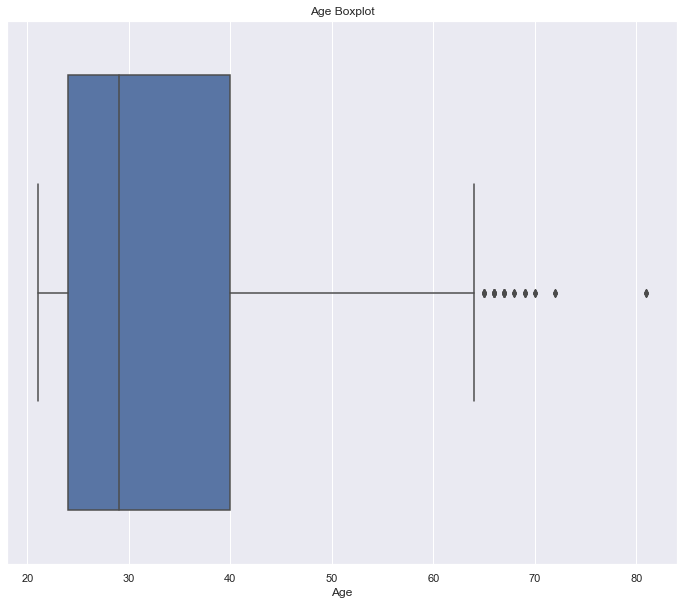

In [143]:
for column in df.columns[:-1]:
    plt.figure(figsize=(12, 10))
    plt.title(f"{column} Boxplot")
    sns.boxplot(data=df, x=column)

To make things even more concrete, we can compute the number of outliers present in each of the columns of our data set:

In [144]:
for column in df.columns[:-1]:
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    outlier_range = (df[column] < (Q1 - 1.5*IQR)) | (df[column] > (Q3 + 1.5 * IQR))
    num_outliers = df[column][outlier_range].count()
    
    print(f"{column}: {num_outliers} outliers")

Pregnancies: 12 outliers
Glucose: 13 outliers
BloodPressure: 125 outliers
SkinThickness: 4 outliers
Insulin: 73 outliers
BMI: 56 outliers
DiabetesPedigreeFunction: 68 outliers
Age: 48 outliers


**Insight**: Looks like our data set contains a large number of outliers; we will need to deal with this later.

## Preparing the Data
Now that we a have a solid understanding of our data, we can begin to clean and prepare it for our models. Because all of our data is already numeric and no two features have a high correlation, there is not much left for us to do, other than address our class imbalance and standardize our data. 

### Splitting our Data
We begin by splitting our data into train and test sets; we must do this *before* any preprocessing so as to avoid any type of [data leakage](https://machinelearningmastery.com/data-leakage-machine-learning/).

In [145]:
# split our data into train/test sets to avoid data leakage
train_df, test_df = train_test_split(df, test_size=0.25, random_state=0)

### Addressing Class Imbalance
As we saw earlier, our data is severely imbalanced; we have a greater number of healthy individuals in our data set than diabetic individuals. If this is still the case in our training set, we will perform [random undersampling](https://machinelearningmastery.com/random-oversampling-and-undersampling-for-imbalanced-classification/#:~:text=Random%20undersampling%20involves%20randomly%20selecting,more%20balanced%20distribution%20is%20reached.) to balance our training set. One way we can achieve this is by removing all duplicate entries that were classified as healthy individuals from our training set.

In [146]:
train_df["Outcome"].value_counts()

0    982
1    518
Name: Outcome, dtype: int64

Evidently, our training set is still heavily imbalanced. Hence, random undersampling needs to be done. One way we can achieve this is by removing all the duplicate entries that were classified as healthy individuals from our training set.

In [147]:
# get all the duplicated rows
train_dups = train_df[train_df.duplicated(subset=None, keep='first')]
# get the index of all the healthy duplicates
healthy_dups = train_dups.loc[train_df["Outcome"] == 0].index
# drop the healthy duplicates
train_df = train_df.drop(healthy_dups)

In [148]:
train_df["Outcome"].value_counts()

1    518
0    464
Name: Outcome, dtype: int64

Now that we've performed random sampling, we can standardize our data. Because we have a large number of outliers, we will be using sklearn's [RobustScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.RobustScaler.html).

In [149]:
# separate the data from the labels
X_train, y_train = train_df.drop(columns=["Outcome"], axis=1), train_df["Outcome"]
X_test, y_test = test_df.drop(columns=["Outcome"], axis=1), test_df["Outcome"]

# create the scaler
scaler = RobustScaler()
# fit the scaler and transform our data
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Model Predictions
Now all that we have left to do is generate some models and make predictions!

In [150]:
def model_Evaluate(model):
    
    # Predict values for Test dataset
    y_pred = model.predict(X_test)

    # Print the evaluation metrics for the dataset.
    print(classification_report(y_test, y_pred))
    
    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)

    categories  = ['Negative','Positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)

    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

### Confusion Matrix

In [151]:
#from sklearn.metrics import confusion_matrix, classification_report
#print(classification_report(y_test, y_pred))

## RandomForest

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       334
           1       0.97      0.99      0.98       166

    accuracy                           0.99       500
   macro avg       0.98      0.99      0.98       500
weighted avg       0.99      0.99      0.99       500



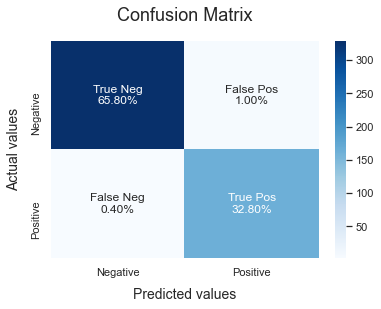

In [152]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
acc_rf= model_Evaluate(rf)

## DecisionTreeClassifier

              precision    recall  f1-score   support

           0       0.99      0.98      0.98       334
           1       0.95      0.99      0.97       166

    accuracy                           0.98       500
   macro avg       0.97      0.98      0.98       500
weighted avg       0.98      0.98      0.98       500



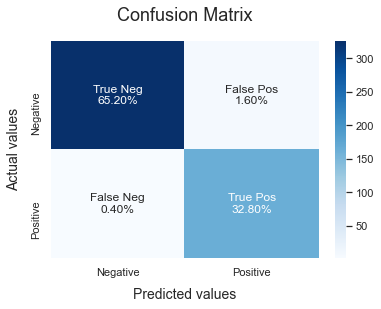

In [153]:
dc = DecisionTreeClassifier()
dc.fit(X_train, y_train)
acc_dc= model_Evaluate(dc)

## KNeighborsClassifier

              precision    recall  f1-score   support

           0       0.91      0.78      0.84       334
           1       0.66      0.84      0.74       166

    accuracy                           0.80       500
   macro avg       0.79      0.81      0.79       500
weighted avg       0.83      0.80      0.81       500



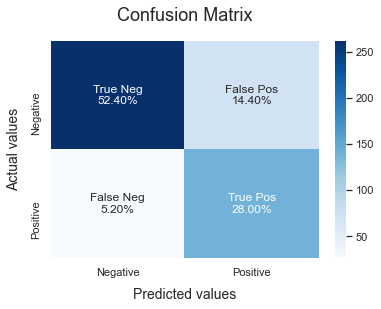

In [154]:
kn = KNeighborsClassifier()
kn.fit(X_train, y_train)
acc_kn= model_Evaluate(kn)

## Logistic Regression

              precision    recall  f1-score   support

           0       0.86      0.75      0.80       334
           1       0.60      0.75      0.67       166

    accuracy                           0.75       500
   macro avg       0.73      0.75      0.74       500
weighted avg       0.78      0.75      0.76       500



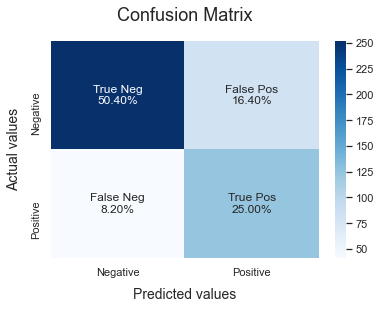

In [155]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
acc_lr= model_Evaluate(lr)

## XGBoost

              precision    recall  f1-score   support

           0       0.99      0.97      0.98       334
           1       0.95      0.98      0.96       166

    accuracy                           0.97       500
   macro avg       0.97      0.97      0.97       500
weighted avg       0.97      0.97      0.97       500



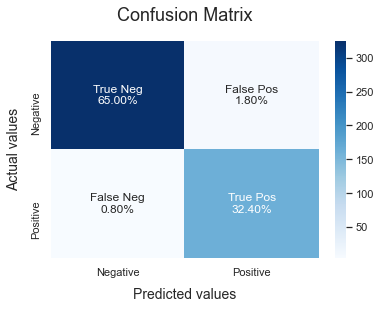

In [156]:
xg = XGBClassifier()
xg.fit(X_train, y_train)
acc_xg= model_Evaluate(xg)

### ROC curve

In [157]:
model_lr = LogisticRegression().fit(X_train, y_train)
probs_lr = model_lr.predict_proba(X_test)[:, 1]

model_dt = DecisionTreeClassifier().fit(X_train, y_train)
probs_dt = model_dt.predict_proba(X_test)[:, 1]

model_kn = KNeighborsClassifier().fit(X_train, y_train)
probs_kn = model_kn.predict_proba(X_test)[:, 1]

model_rf = RandomForestClassifier().fit(X_train, y_train)
probs_rf = model_rf.predict_proba(X_test)[:, 1]

model_xg = XGBClassifier().fit(X_train, y_train)
probs_xg = model_xg.predict_proba(X_test)[:, 1]

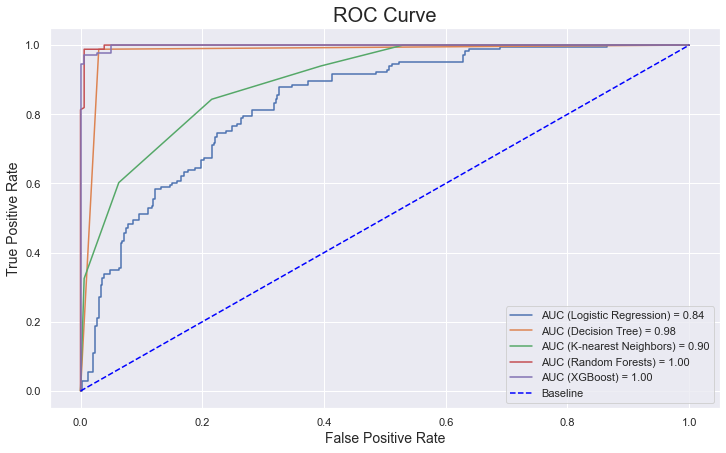

In [158]:
from sklearn.metrics import roc_auc_score, roc_curve

y_test_int = y_test.replace({'Good': 1, 'Bad': 0})
auc_lr = roc_auc_score(y_test_int, probs_lr)
fpr_lr, tpr_lr, thresholds_lr = roc_curve(y_test_int, probs_lr)

auc_dt = roc_auc_score(y_test_int, probs_dt)
fpr_dt, tpr_dt, thresholds_dt = roc_curve(y_test_int, probs_dt)

auc_kn = roc_auc_score(y_test_int, probs_kn)
fpr_kn, tpr_kn, thresholds_kn = roc_curve(y_test_int, probs_kn)

auc_rf = roc_auc_score(y_test_int, probs_rf)
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test_int, probs_rf)

auc_xg = roc_auc_score(y_test_int, probs_xg)
fpr_xg, tpr_xg, thresholds_xg = roc_curve(y_test_int, probs_xg)

plt.figure(figsize=(12, 7))
plt.plot(fpr_lr, tpr_lr, label=f'AUC (Logistic Regression) = {auc_lr:.2f}')
plt.plot(fpr_dt, tpr_dt, label=f'AUC (Decision Tree) = {auc_dt:.2f}')
plt.plot(fpr_kn, tpr_kn, label=f'AUC (K-nearest Neighbors) = {auc_kn:.2f}')
plt.plot(fpr_rf, tpr_rf, label=f'AUC (Random Forests) = {auc_rf:.2f}')
plt.plot(fpr_xg, tpr_xg, label=f'AUC (XGBoost) = {auc_xg:.2f}')
plt.plot([0, 1], [0, 1], color='blue', linestyle='--', label='Baseline')
plt.title('ROC Curve', size=20)
plt.xlabel('False Positive Rate', size=14)
plt.ylabel('True Positive Rate', size=14)
plt.legend();